Te pongo un ejemplo de como representar una lista de puntos con sus coordenadas en RA y Dec. La única manera sencilla que se me ocurre es leyendo el header de un fits, aunque luego no vayas a enseñar la imagen y solo grafiques puntos.

In [1]:
# astroquery es un paquete se conecta a simbad y permite coger
# de la base de datos algunas medidas como, por ejemplo,
# posiciones de estrellas. Si tienes las coordenadas en algún archivo,
# estepaquete no te hará falta
from astroquery.simbad import Simbad

import numpy as np

from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

# Super util este paquete, te ayuda a definir coordenadas en RA-Dec de fuentes, y calcular distancias, ángulos, convertir en coordenadas relativas, etc
from astropy.coordinates import SkyCoord, Angle

# Este paquete te olvidas completamente de tener que hacer conversiones de unidades
import astropy.units as u

import pandas as pd

import matplotlib.pyplot as plt

Si ya tienes un archivo con las estrellas que quieres representar, saltate esta celda. Pero míralo como ejemplo si quieres, por si alguna vez quieres buscar en Simbad

In [2]:
# Defino las coordenadas del centro de la región. En este caso yo selecciono vla4b (la componente del este de SVS13)
vla4b_coords = SkyCoord(ra='03h29m3.7454s', dec='31d16m3.784s',
                        frame='icrs')

# Cojo los datos de simbad y guardo en un pandas dataframe
sources_table = Simbad.query_region(vla4b_coords,
                                   radius='0d1m0s').to_pandas()

# esto guarda los datos en un csv
sources_table.to_csv("sources_around_vla4b")

Leo la tabla de las coordenadas, igual tu lo haces de otra manera, pero lo importante es que puedas tener una lista de las coordenadas 

In [3]:
# esto los lee
sources_table = pd.read_csv("sources_around_vla4b")

# Si quieres imprimir la tabla
print(sources_table)

    Unnamed: 0                 MAIN_ID             RA            DEC  RA_PREC  \
0            0  [TLL2016] Per-emb-44-B  03 29 03.7430  +31 16 03.790        8   
1            1    [SVS76] NGC 1333 13A    03 29 03.73    +31 16 03.8        6   
2            2             V* V512 Per  03 29 03.7567  +31 16 03.959       14   
3            3  [TLL2016] Per-emb-44-A  03 29 03.7660  +31 16 03.810        8   
4            4         [RAC97] VLA  4b   03 29 03.740   +31 16 04.15        7   
..         ...                     ...            ...            ...      ...   
57          57           NAME ASR 106B   03 28 59.300   +31 15 49.10        7   
58          58                 ASR 106  03 28 59.3064  +31 15 48.517        9   
59          59       [SB86] NGC 1333 6     03 29 02.3      +31 15 07        5   
60          60           NAME ASR 106A   03 28 59.220   +31 15 49.06        7   
61          61          [RAC97] VLA 18    03 29 03.38    +31 15 04.0        6   

    DEC_PREC  COO_ERR_MAJA 

La siguiente celda dependerá de como tienes las coordenadas definidas en la tabla. Yo supongo que las coordenadas las tienes en hms en RA, y dms en dec. La mejor manera es convertir estas coordenadas en objetos de python de tipo SkyCoord, que es super útil. Yo normalmente los defino así:

fuente = SkyCoord(ra='XXhXXmXX.Xs', dec='XXdXXmX.XXXs',
                        frame='icrs')
                        
Hay muchas otras formas de definirlos:
https://docs.astropy.org/en/stable/coordinates/index.html                     

De hecho, en la tabla de simbad están puestos como 03 29 03.7430  +31 16 03.790, así que me es más facil definir los SkyCoords de la siguiente manera:

SkyCoord("03 29 03.7430  +31 16 03.790", unit=(u.hourangle, u.deg))  

In [4]:
# La tabla source_table tiene los datos de las coordenadas de todas las fuentes que quiero graficar. 
sources_table["skycoord"] = np.zeros(sources_table.shape[0])
for i in sources_table.index:
        # creo objetos de tipo SkyCoord dándole las coordenadas
        sources_table.loc[i,"skycoord"] = SkyCoord(sources_table.loc[i].RA + ' ' + sources_table.loc[i].DEC,
                                            unit=(u.hourangle, u.deg))    

Para poder hacer un plot con coordenadas RA y Dec, la única sencilla que se me ocurre es leyendo el header de un fits. A mí me va a ser vir como ejemplo uno mío de SVS13. Yo te recomendaría que cogieras uno de los que te vayan a dar (aunque puedes intentar hacer la prueba con este fits, aunque solo te importe el header)

In [5]:
# Abrimos el fits
hdu = fits.open("example.fits")[0]

# Header del fits
hdr = hdu.header

# el wcs contiene la información para transformar las coordenadas de cielo en pixel, y viceversa, teniendo en cuenta el header del fits.
wcs = WCS(hdu.header).celestial

# Array de la imagen
image_data = hdu.data[0]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Representamos lista de fuentes

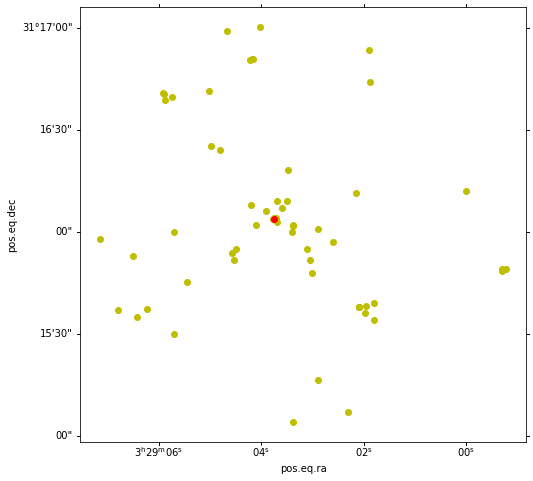

In [6]:
fig = plt.figure(figsize=(8,8))

# pasamos el wcs a matplotlib para que pueda representar los puntos en coordenadas celestes
ax = plt.subplot(projection=wcs) # aitoff

# cogemos los ra y los dec de la lista
ras = [sky.ra.deg for sky in sources_table.skycoord]
decs = [sky.dec.deg for sky in sources_table.skycoord]   
 
# Hacemos un scatter de todas las posiciones (creo que me dijiste que utilizabas scatter)
ax.scatter(ras, decs, c='y', transform=ax.get_transform("icrs"))

# También puedes representar puntos individuales, por ejemplo, nuestras posiciones de vla4b en rojo
ax.plot(vla4b_coords.ra.deg, vla4b_coords.dec.deg, "or", transform=ax.get_transform("icrs"), )

fig.savefig("ejemplo_wcs.png")